In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib widget

import importlib
import os
import sys

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import TurbidostatClass
import tools

importlib.reload(TurbidostatClass)
importlib.reload(tools)

<module 'tools' from 'c:\\Users\\Orlando\\Desktop\\DREAM_repo\\tools.py'>

In [2]:
turbido = TurbidostatClass.Turbidostat('20230823_steady_chlamy_WT4A_new')

In [16]:
turbido.data["ch1"].keys()

dict_keys(['od-680', 'light', 'consumption'])

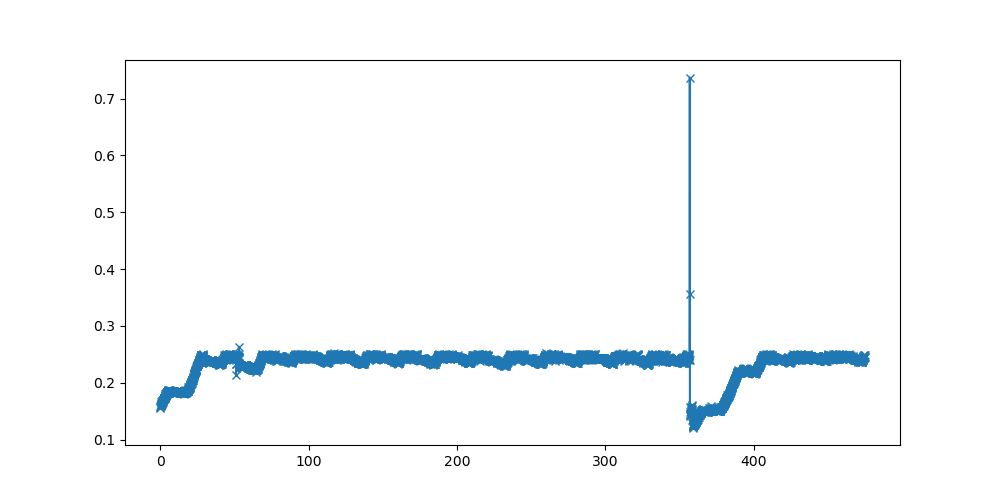

In [25]:
fig, ax = plt.subplots(1,1, figsize=(10,5)) 
ax.plot(turbido.data['ch3']['od-680']['time']/(60*60), turbido.data['ch3']['od-680']['val'], 'x-')

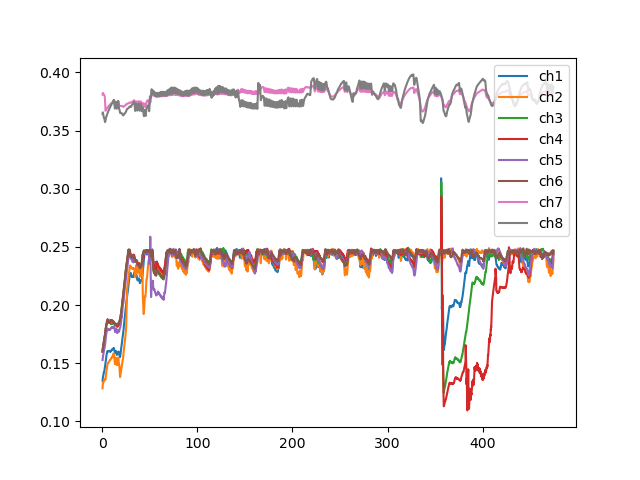

In [23]:
import mvgavg.mvgavg as mvgavg
avg = 10
fig, ax = plt.subplots()
for channel in range(8):
    ax.plot(mvgavg(turbido.data[f'ch{channel+1}']['od-680'].time/(60*60), avg), mvgavg(turbido.data[f'ch{channel+1}']['od-680'].val, avg), '-', label = f'ch{channel+1}')
ax.legend()

In [5]:
channel

7

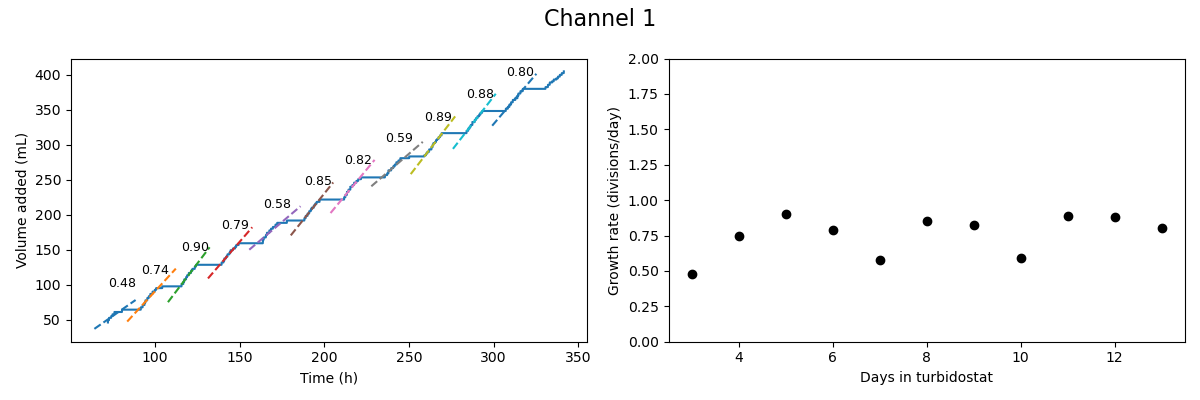

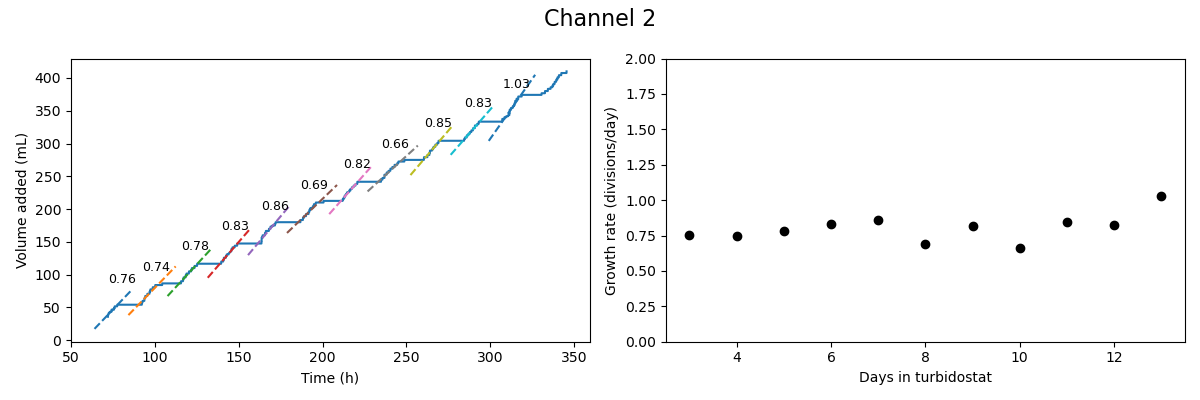

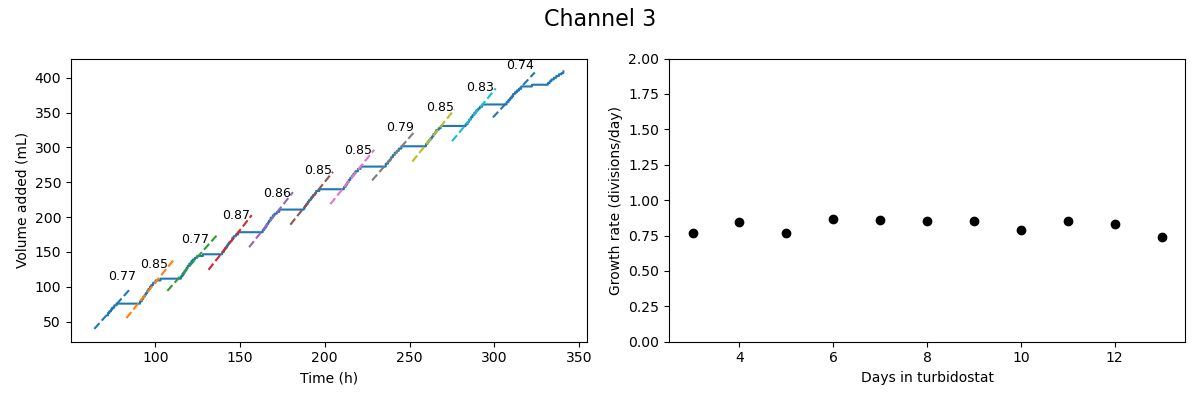

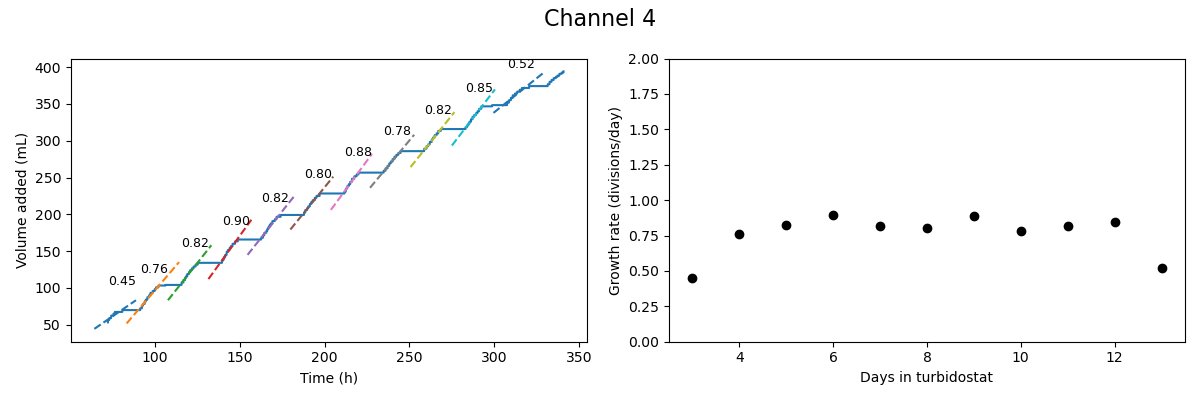

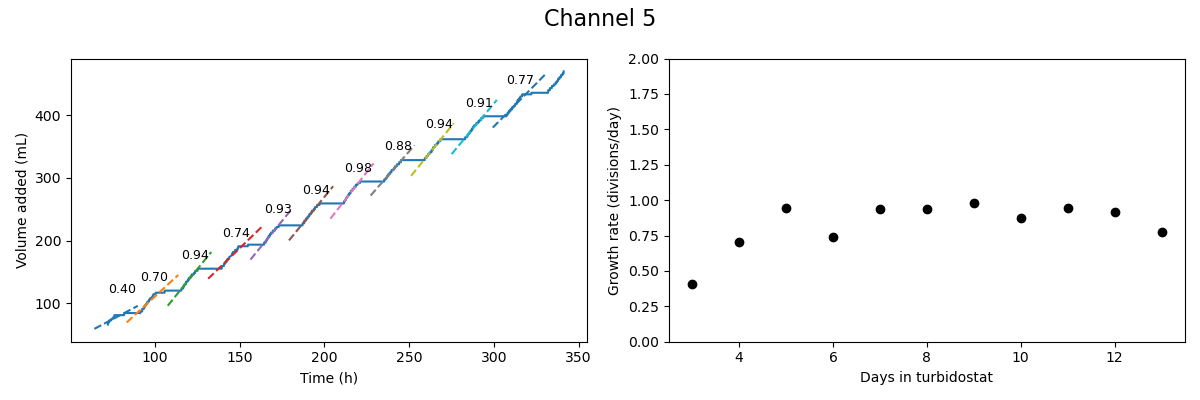

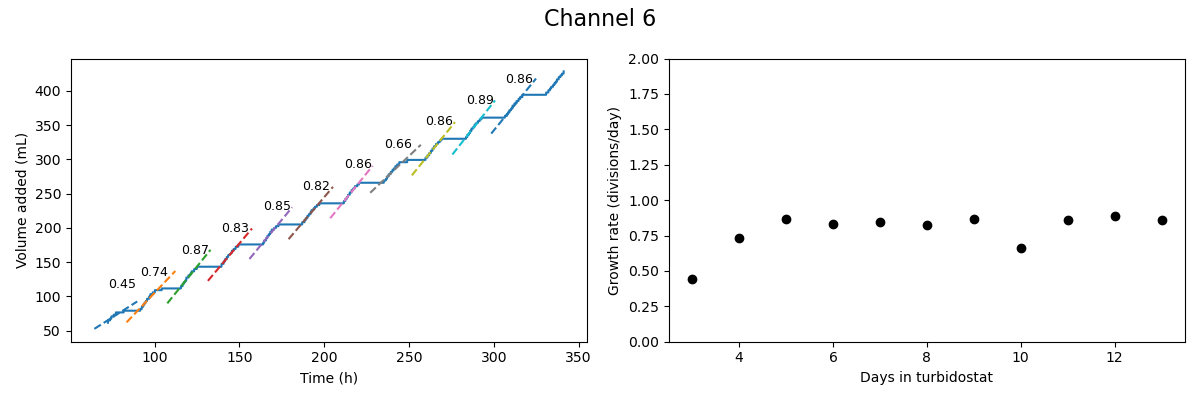

In [6]:
def get_growth_rate_plots(x, y, channel):
    x= np.array(x)
    y = np.array(y)
    times = []
    growth_period = []
    start = None
    for i in range(len(y)):
        if i == 0:
            pass
        elif start is None:
            start = i
        elif x[i]-x[i-1] > 6:
            if y[i] - y[start] > 5:
                times.append(x[start:i])
                growth_period.append(y[start:i])
            start = None
        else:
            continue

    fig, ax = plt.subplots(1,2, figsize = (12,4))
    title = fig.suptitle(f'Channel {channel}', fontsize=16)
    ax[0].plot(x, y)

    growth_rate = []
    colors = []

    for i in range(len(times)):
        popt = []
        xfit = []
        yfit = []
        colors.append(f'C{i}')
        popt, xfit, yfit = tools.lin_fit(times[i], growth_period[i], times[i][0]-8, times[i][-1]+8, 100)
        growth_rate.append(popt[0]*12/42.5)
        ax[0].plot(xfit, yfit, '--', color = colors[i])
        ax[0].text(times[i][0], growth_period[i][0]+50, f'{growth_rate[i]:.2f}', fontsize=9)
    ax[0].set_xlabel('Time (h)')
    ax[0].set_ylabel('Volume added (mL)')
        
    ax[1].scatter(np.arange(0,len(growth_rate))+3, growth_rate, c = 'k')
    ax[1].set_ylim(0,2)
    ax[1].set_xlabel('Days in turbidostat')
    ax[1].set_ylabel('Growth rate (divisions/day)')
    
    fig.tight_layout()
    fig.savefig(f'{turbido.fig_folder}/Channel_{channel}_growth_rate.png', dpi = 300)
    
    return fig, ax, growth_rate

growth_rates = []
t_start = 72 # hours
t_end = 350 # hours
for i in range(6):
    x = turbido.data[f'ch{i+1}']['consumption']['time']/(60*60)
    index_start = np.where(x > t_start)[0][0]
    index_end = np.where(x > t_end)[0][0]
    x = x[index_start:index_end]
    y = turbido.data[f'ch{i+1}']['consumption']['val'][index_start:index_end]
    growth_rates.append(get_growth_rate_plots(x, y, i+1))
    



    


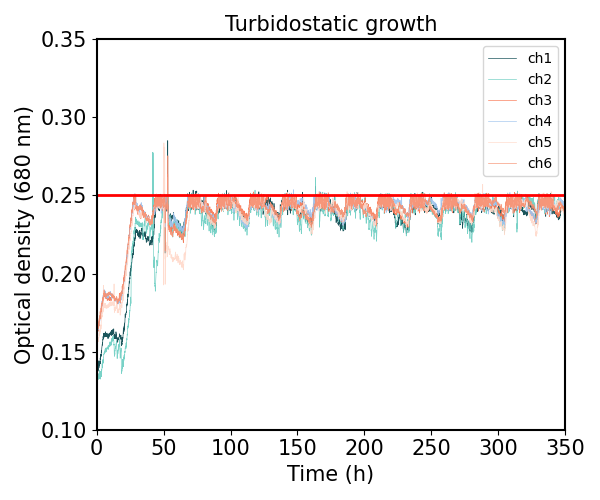

In [7]:
import DREAM_colors as dc
importlib.reload(dc)
importlib.reload(tools)

#colors = dc.colors.rgb[[1,5,9,0,4,8,6]].reset_index(drop=True)
colors = dc.get_random_colors(6)

t_start = 1 # hours
t_end = 350 # hours

fig, ax = plt.subplots(1,1, figsize=(6,5))
for i in range(6):
    x = turbido.data[f'ch{i+1}']['od-680']['time']/(60*60)
    index_start = np.where(x > t_start)[0][0]
    index_end = np.where(x > t_end)[0][0]
    x = x[index_start:index_end]
    y = turbido.data[f'ch{i+1}']['od-680']['val'][index_start:index_end]
    ax.plot(x, y, label = f'ch{i+1}', color = colors[i], alpha = 0.9, linewidth = 0.5)

ax.set_ylim(0.1,0.35)
ax.set_xlim(0,350)

ax.hlines(0.25, 0, 350, color = 'r', linewidth = 2)

ax = tools.poster_axes(ax, title = 'Turbidostatic growth', xlabel = 'Time (h)', ylabel = 'Optical density (680 nm)')

fig.tight_layout()

fig.savefig(f'{turbido.fig_folder}/OD680.png', dpi = 300)
    



In [8]:
def get_growth_rate_plots(x, y, channel):
    x= np.array(x)
    y = np.array(y)
    times = []
    growth_period = []
    start = None
    for i in range(len(y)):
        if i == 0:
            pass
        elif start is None:
            start = i
        elif x[i]-x[i-1] > 6:
            if y[i] - y[start] > 5:
                times.append(x[start:i])
                growth_period.append(y[start:i])
            start = None
        else:
            continue

    fig, ax = plt.subplots(2,1, figsize = (12*.7,10*.7))
    #title = fig.suptitle(f'Channel {channel}', fontsize=16)
    ax[0].plot(x, y)

    growth_rate = []
    colors = []

    for i in range(len(times)):
        popt = []
        xfit = []
        yfit = []
        colors.append(f'C{i}')
        popt, xfit, yfit = tools.lin_fit(times[i], growth_period[i], times[i][0]-8, times[i][-1]+8, 100)
        growth_rate.append(popt[0]*12/42.5)
        ax[0].plot(xfit, yfit, '--', color = colors[i])
        ax[0].text(times[i][0], growth_period[i][0]+50, f'{growth_rate[i]:.2f}', fontsize=9)
    ax[0].set_xlabel('Time (h)')
    ax[0].set_ylabel('Volume added (mL)')
        
    ax[1].scatter(np.arange(0,len(growth_rate))+3, growth_rate, c = 'k')
    ax[1].set_ylim(0,2)
    ax[1].set_xlabel('Days in turbidostat')
    ax[1].set_ylabel('Growth rate (divisions/day)')
    
    fig.tight_layout()
    fig.savefig(f'{turbido.fig_folder}/Channel_{channel}_growth_rate.png', dpi = 300)
    
    return fig, ax, growth_rate

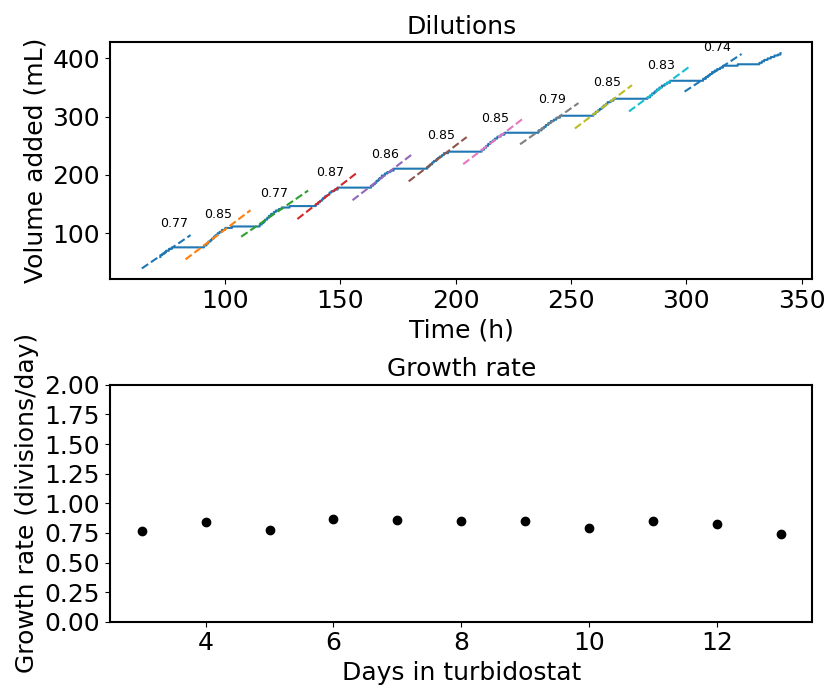

In [9]:
t_start = 72 # hours
t_end = 350 # hours
channel = 3

x = turbido.data[f'ch{channel}']['consumption']['time']/(60*60)
index_start = np.where(x > t_start)[0][0]
index_end = np.where(x > t_end)[0][0]
x = x[index_start:index_end]
y = turbido.data[f'ch{channel}']['consumption']['val'][index_start:index_end]
fig, ax, growth_rate = get_growth_rate_plots(x, y, channel)

ax[0] = tools.poster_axes(ax[0], title = "Dilutions", xlabel = 'Time (h)', ylabel = 'Volume added (mL)', labelsize= 18, titlesize=18, legend=False) 
ax[1] = tools.poster_axes(ax[1], title = "Growth rate", xlabel = 'Days in turbidostat', ylabel = 'Growth rate (divisions/day)', labelsize= 18, titlesize=18, legend=False)

fig.tight_layout()

fig.savefig(f'{turbido.fig_folder}/Channel_{channel}_growth_rate_poster.png', dpi = 300)


In [10]:
dc.colors

,name,hex,rgb,cmyk,hsb,hsl,lab
0,Tiffany Blue,6ACDC1,"[0.41568627450980394, 0.803921568627451, 0.756...","[48, 0, 6, 20]","[173, 48, 80]","[173, 50, 61]","[76, -32, -3]"
1,Persian green,07AB98,"[0.027450980392156862, 0.6705882352941176, 0.5...","[96, 0, 11, 33]","[173, 96, 67]","[173, 92, 35]","[63, -41, -1]"
2,Skobeloff,16817A,"[0.08627450980392157, 0.5058823529411764, 0.47...","[83, 0, 5, 49]","[176, 83, 51]","[176, 71, 30]","[49, -30, -4]"
3,Midnight green,024249,"[0.00784313725490196, 0.25882352941176473, 0.2...","[97, 10, 0, 71]","[186, 97, 29]","[186, 95, 15]","[25, -15, -10]"
4,Pale Dogwood,FFD9CA,"[1.0, 0.8509803921568627, 0.792156862745098]","[0, 15, 21, 0]","[17, 21, 100]","[17, 100, 90]","[89, 11, 12]"
5,Coral,F79071,"[0.9686274509803922, 0.5647058823529412, 0.443...","[0, 42, 54, 3]","[14, 54, 97]","[14, 89, 71]","[70, 36, 33]"
6,Burnt sienna,FA744F,"[0.9803921568627451, 0.4549019607843137, 0.309...","[0, 54, 68, 2]","[13, 68, 98]","[13, 94, 65]","[64, 49, 45]"
7,Jasper,BB573B,"[0.7333333333333333, 0.3411764705882353, 0.231...","[0, 53, 68, 27]","[13, 68, 73]","[13, 52, 48]","[49, 38, 35]"
8,Alice Blue,DFEBF9,"[0.8745098039215686, 0.9215686274509803, 0.976...","[10, 6, 0, 2]","[212, 10, 98]","[212, 68, 93]","[93, -1, -8]"
9,Jordy Blue,9FC3ED,"[0.6235294117647059, 0.7647058823529411, 0.929...","[33, 18, 0, 7]","[212, 33, 93]","[212, 68, 78]","[78, -2, -25]"


In [11]:
import numpy as np
import pandas as pd

blue = [{"name":"Alice Blue","hex":"DFEBF9","rgb":[223,235,249],"cmyk":[10,6,0,2],"hsb":[212,10,98],"hsl":[212,68,93],"lab":[93,-1,-8]},{"name":"Jordy Blue","hex":"9FC3ED","rgb":[159,195,237],"cmyk":[33,18,0,7],"hsb":[212,33,93],"hsl":[212,68,78],"lab":[78,-2,-25]},{"name":"Blue Gray","hex":"5F9BE1","rgb":[95,155,225],"cmyk":[58,31,0,12],"hsb":[212,58,88],"hsl":[212,68,63],"lab":[63,1,-41]},{"name":"Lapis Lazuli","hex":"305E94","rgb":[48,94,148],"cmyk":[68,36,0,42],"hsb":[212,68,58],"hsl":[212,51,38],"lab":[39,3,-34]}]
green = [{"name":"Tiffany Blue","hex":"6ACDC1","rgb":[106,205,193],"cmyk":[48,0,6,20],"hsb":[173,48,80],"hsl":[173,50,61],"lab":[76,-32,-3]},{"name":"Persian green","hex":"07AB98","rgb":[7,171,152],"cmyk":[96,0,11,33],"hsb":[173,96,67],"hsl":[173,92,35],"lab":[63,-41,-1]},{"name":"Skobeloff","hex":"16817A","rgb":[22,129,122],"cmyk":[83,0,5,49],"hsb":[176,83,51],"hsl":[176,71,30],"lab":[49,-30,-4]},{"name":"Midnight green","hex":"024249","rgb":[2,66,73],"cmyk":[97,10,0,71],"hsb":[186,97,29],"hsl":[186,95,15],"lab":[25,-15,-10]}]
orange = [{"name":"Pale Dogwood","hex":"FFD9CA","rgb":[255,217,202],"cmyk":[0,15,21,0],"hsb":[17,21,100],"hsl":[17,100,90],"lab":[89,11,12]},{"name":"Coral","hex":"F79071","rgb":[247,144,113],"cmyk":[0,42,54,3],"hsb":[14,54,97],"hsl":[14,89,71],"lab":[70,36,33]},{"name":"Burnt sienna","hex":"FA744F","rgb":[250,116,79],"cmyk":[0,54,68,2],"hsb":[13,68,98],"hsl":[13,94,65],"lab":[64,49,45]},{"name":"Jasper","hex":"BB573B","rgb":[187,87,59],"cmyk":[0,53,68,27],"hsb":[13,68,73],"hsl":[13,52,48],"lab":[49,38,35]}]

[]

blue_df = pd.DataFrame(blue)
green_df = pd.DataFrame(green)
orange_df = pd.DataFrame(orange)

colors = [{"name":"Tiffany Blue","hex":"6ACDC1","rgb":[106,205,193],"cmyk":[48,0,6,20],"hsb":[173,48,80],"hsl":[173,50,61],"lab":[76,-32,-3]},{"name":"Persian green","hex":"07AB98","rgb":[7,171,152],"cmyk":[96,0,11,33],"hsb":[173,96,67],"hsl":[173,92,35],"lab":[63,-41,-1]},{"name":"Skobeloff","hex":"16817A","rgb":[22,129,122],"cmyk":[83,0,5,49],"hsb":[176,83,51],"hsl":[176,71,30],"lab":[49,-30,-4]},{"name":"Midnight green","hex":"024249","rgb":[2,66,73],"cmyk":[97,10,0,71],"hsb":[186,97,29],"hsl":[186,95,15],"lab":[25,-15,-10]},
          {"name":"Pale Dogwood","hex":"FFD9CA","rgb":[255,217,202],"cmyk":[0,15,21,0],"hsb":[17,21,100],"hsl":[17,100,90],"lab":[89,11,12]},{"name":"Coral","hex":"F79071","rgb":[247,144,113],"cmyk":[0,42,54,3],"hsb":[14,54,97],"hsl":[14,89,71],"lab":[70,36,33]},{"name":"Burnt sienna","hex":"FA744F","rgb":[250,116,79],"cmyk":[0,54,68,2],"hsb":[13,68,98],"hsl":[13,94,65],"lab":[64,49,45]},{"name":"Jasper","hex":"BB573B","rgb":[187,87,59],"cmyk":[0,53,68,27],"hsb":[13,68,73],"hsl":[13,52,48],"lab":[49,38,35]},
          {"name":"Alice Blue","hex":"DFEBF9","rgb":[223,235,249],"cmyk":[10,6,0,2],"hsb":[212,10,98],"hsl":[212,68,93],"lab":[93,-1,-8]},{"name":"Jordy Blue","hex":"9FC3ED","rgb":[159,195,237],"cmyk":[33,18,0,7],"hsb":[212,33,93],"hsl":[212,68,78],"lab":[78,-2,-25]},{"name":"Blue Gray","hex":"5F9BE1","rgb":[95,155,225],"cmyk":[58,31,0,12],"hsb":[212,58,88],"hsl":[212,68,63],"lab":[63,1,-41]},{"name":"Lapis Lazuli","hex":"305E94","rgb":[48,94,148],"cmyk":[68,36,0,42],"hsb":[212,68,58],"hsl":[212,51,38],"lab":[39,3,-34]}]
colors = pd.DataFrame(colors)
colors.rgb = colors.rgb.apply(lambda x: np.array(x)/255)

In [12]:
colors

,name,hex,rgb,cmyk,hsb,hsl,lab
0,Tiffany Blue,6ACDC1,"[0.41568627450980394, 0.803921568627451, 0.756...","[48, 0, 6, 20]","[173, 48, 80]","[173, 50, 61]","[76, -32, -3]"
1,Persian green,07AB98,"[0.027450980392156862, 0.6705882352941176, 0.5...","[96, 0, 11, 33]","[173, 96, 67]","[173, 92, 35]","[63, -41, -1]"
2,Skobeloff,16817A,"[0.08627450980392157, 0.5058823529411764, 0.47...","[83, 0, 5, 49]","[176, 83, 51]","[176, 71, 30]","[49, -30, -4]"
3,Midnight green,024249,"[0.00784313725490196, 0.25882352941176473, 0.2...","[97, 10, 0, 71]","[186, 97, 29]","[186, 95, 15]","[25, -15, -10]"
4,Pale Dogwood,FFD9CA,"[1.0, 0.8509803921568627, 0.792156862745098]","[0, 15, 21, 0]","[17, 21, 100]","[17, 100, 90]","[89, 11, 12]"
5,Coral,F79071,"[0.9686274509803922, 0.5647058823529412, 0.443...","[0, 42, 54, 3]","[14, 54, 97]","[14, 89, 71]","[70, 36, 33]"
6,Burnt sienna,FA744F,"[0.9803921568627451, 0.4549019607843137, 0.309...","[0, 54, 68, 2]","[13, 68, 98]","[13, 94, 65]","[64, 49, 45]"
7,Jasper,BB573B,"[0.7333333333333333, 0.3411764705882353, 0.231...","[0, 53, 68, 27]","[13, 68, 73]","[13, 52, 48]","[49, 38, 35]"
8,Alice Blue,DFEBF9,"[0.8745098039215686, 0.9215686274509803, 0.976...","[10, 6, 0, 2]","[212, 10, 98]","[212, 68, 93]","[93, -1, -8]"
9,Jordy Blue,9FC3ED,"[0.6235294117647059, 0.7647058823529411, 0.929...","[33, 18, 0, 7]","[212, 33, 93]","[212, 68, 78]","[78, -2, -25]"
